# Ball control

This script is intended to determine the team and location of possession:

+ **BallControl**: A boolean telling us whether the team is in possession (for both teams)
+ **BallControlArea**: A boolean telling us whether the team is in possession within a certain area of the pitch that can be passed as a variable (for both teams) 


This will later be transformed into function stored in a py.-file  <br>

In [1]:
from floodlight import Pitch
from floodlight.io import dfl
from pies import SuccessScore as ss
import numpy as np
import copy

In [2]:
# read position data and match information file
position_file = 'PositionData/DFL_04_02_positions_raw_DFL-COM-000001_DFL-MAT-0027AD.xml'
matchinfo ='MI_Data/DFL_02_01_matchinformation_DFL-COM-000001_DFL-MAT-0027AD-Copy1.xml'

# returns multipe objects; at this point we only care about the positions (xy_objects) and the pitch object (pitch)
xy_objects, possession_objects, ballstatus_objects, teamsheets, pitch = dfl.read_position_data_xml(filepath_positions=position_file,
                          filepath_mat_info=matchinfo)

### Option 1
Trust the possession dummy supplied by dfl data and check if ball is within the selcted area at the same time! 

In [3]:
# requires a pitch object!
# area specific limits 

area_codes = {'penalty area': {
                'left':{
                    'xmin' : pitch.xlim[0],
                    'xmax' : pitch.xlim[0] + 16.5,
                    'ymin' : pitch.ylim[1] - (pitch.ylim[1] - pitch.ylim[0])/2 - 20.16,
                    'ymax' : pitch.ylim[1] - (pitch.ylim[1] - pitch.ylim[0])/2 + 20.16,
                },
                'right': {
                    'xmin' : pitch.xlim[1] - 16.5,
                    'xmax' : pitch.xlim[1],
                    'ymin' : pitch.ylim[1] - (pitch.ylim[1] - pitch.ylim[0])/2 - 20.16,
                    'ymax' : pitch.ylim[1] - (pitch.ylim[1] - pitch.ylim[0])/2 + 20.16,
                }
},
              'final third': {
                  'left':{
                      'xmin' : pitch.xlim[0],
                      'xmax' : pitch.xlim[0] + (pitch.xlim[1] - pitch.xlim[0])/3,
                      'ymin' : pitch.ylim[0],
                      'ymax' : pitch.ylim[1],
                    },
                  'right': {
                      'xmin' : pitch.xlim[1] - (pitch.xlim[1] - pitch.xlim[0])/3,
                      'xmax' : pitch.xlim[1],
                      'ymin' : pitch.ylim[0],
                      'ymax' : pitch.ylim[1],
                    }
}, 
              '30m': {
                  'left':{
                      'xmin' : pitch.xlim[0],
                      'xmax' : pitch.xlim[0] + 30,
                      'ymin' : pitch.ylim[0],
                      'ymax' : pitch.ylim[1],
                    },
                  'right': {
                      'xmin' : pitch.xlim[1] - 30,
                      'xmax' : pitch.xlim[1],
                      'ymin' : pitch.ylim[0],
                      'ymax' : pitch.ylim[1],
                    }
},  
              'half': {
                  'left':{
                      'xmin' : pitch.xlim[0],
                      'xmax' : pitch.xlim[0] + (pitch.xlim[1] - pitch.xlim[0])/2,
                      'ymin' : pitch.ylim[0],
                      'ymax' : pitch.ylim[1],
                    },
                  'right': {
                      'xmin' : pitch.xlim[1] - (pitch.xlim[1] - pitch.xlim[0])/2,
                      'xmax' : pitch.xlim[1],
                      'ymin' : pitch.ylim[0],
                      'ymax' : pitch.ylim[1],
                    }
}}
                            

In [4]:
# use deepcopy to avoid the overwriting in PO 
PO = copy.deepcopy(possession_objects)
BC_A1 = copy.deepcopy(PO['firstHalf'].code)
BC_B1 = copy.deepcopy(PO['firstHalf'].code)
BC_A2 = copy.deepcopy(PO['secondHalf'].code)
BC_B2 = copy.deepcopy(PO['secondHalf'].code)

# convert to 0 and 1 (=possession) for each team and each half
BC_A1[BC_A1 == 1] = 1
BC_A1[BC_A1 == 2] = 0

BC_B1[BC_B1 == 1] = 0
BC_B1[BC_B1 == 2] = 1

BC_A2[BC_A2 == 1] = 1
BC_A2[BC_A2 == 2] = 0

BC_B2[BC_B2 == 1] = 0
BC_B2[BC_B2 == 2] = 1


In [5]:
direction_A1 = 'ltr' # direction of Team A in half 1
area = 'final third' # area of interest

# position data of the ball
P_b1 = xy_objects['firstHalf']['Ball']
P_b2 = xy_objects['secondHalf']['Ball']


# ball control booleans for the specific area!
BC_A1_area = []
BC_B1_area = []
BC_A2_area = []
BC_B2_area = []

new = [BC_A1_area, BC_B1_area, BC_A2_area, BC_B2_area]


for v, V in enumerate([BC_A1, BC_B1, BC_A2, BC_B2]):
    
    if v == 0 or v == 3:
        direction = 'right'
    elif v == 1 or v == 2:
        direction == 'left'
    
    if v <= 1:
        ball = P_b1
    elif v == 2 or v ==3:
        ball = P_b2
    
    T = len(V)
    print(v)
    print(T)
    for t in range(T):
        if V[t] == 1:
            x = ball.frame(t)[0] # x position of ball
            y = ball.frame(t)[1] # y position of ball
        
          
            if x <= area_codes[area][direction]['xmax'] and x >= area_codes[area][direction]['xmin']:
                new[v].append(1)
            else:
                new[v].append(0)
        else: 
            new[v].append(0)


0
67780
1
67780
2
69439
3
69439


### Option 2
À la SOCCER - less than 1m and opponent more than 1m = possession <br>


In [6]:
from scipy.spatial.distance import cdist

direction_A1 = 'ltr' # direction of Team A in half 1
area = 'final third' # area of interest

P_A1 = xy_objects['firstHalf']['Home'] # Team A position first half
P_B1 = xy_objects['firstHalf']['Away'] # Team B
P_A2 = xy_objects['secondHalf']['Home'] # Team A positions second half
P_B2 = xy_objects['secondHalf']['Away'] # Team B
P_b1 = xy_objects['firstHalf']['Ball'] # ball positions second half
P_b2 = xy_objects['secondHalf']['Ball'] # ball


BC_A1 = []     # storing the ball control events per team and half
BC_B1 = []
BC_A2 = []
BC_B2 = []


T = len(P_A1)

# determine closest team for each frame for first half
for t in range(T):
    # reformat coordinates
    A1_points = np.hstack((P_A1.frame(t))).reshape(-1, 2)
    B1_points = np.hstack((P_B1.frame(t))).reshape(-1, 2)
    b1_points = np.hstack((P_b1.frame(t))).reshape(-1, 2)
    
    # calculate each players distance to the ball
    A_distances = cdist(A1_points, b1_points)
    B_distances = cdist(B1_points, b1_points)
    
    A_closest = np.nanmin(A_distances)
    B_closest = np.nanmin(B_distances)
    
    
    if A_closest < 1:
        if B_closest >= 1:
            BC_A1.append(1)
            BC_B1.append(0)
        else:
            BC_A1.append(0)
            BC_B1.append(0)
    elif B_closest < 1:
        BC_A1.append(0)
        BC_B1.append(1)
    else:
        BC_A1.append(0)
        BC_B1.append(0)        



# determine closest team for each frame for second half
for t in range(T):
    # reformat coordinates
    A2_points = np.hstack((P_A2.frame(t))).reshape(-1, 2)
    B2_points = np.hstack((P_B2.frame(t))).reshape(-1, 2)
    b2_points = np.hstack((P_b2.frame(t))).reshape(-1, 2)
    
    # calculate each players distance to the ball
    A_distances = cdist(A2_points, b2_points)
    B_distances = cdist(B2_points, b2_points)
    
    A_closest = np.nanmin(A_distances)
    B_closest = np.nanmin(B_distances)
    
    
    if A_closest < 1:
        if B_closest >= 1:
            BC_A2.append(1)
            BC_B2.append(0)
        else:
            BC_A2.append(0)
            BC_B2.append(0)
    elif B_closest < 1:
        BC_A2.append(0)
        BC_B2.append(1)
    else:
        BC_A2.append(0)
        BC_B2.append(0)        
        
        
# ball control booleans for the specific area!
BC_A1_area = []
BC_B1_area = []
BC_A2_area = []
BC_B2_area = []

new = [BC_A1_area, BC_B1_area, BC_A2_area, BC_B2_area]


for v, V in enumerate([BC_A1, BC_B1, BC_A2, BC_B2]):
    
    if v == 0 or v == 3:
        direction = 'right'
    elif v == 1 or v == 2:
        direction == 'left'
    
    if v <= 1:
        ball = P_b1
    elif v == 2 or v ==3:
        ball = P_b2
    
    T = len(V)

    for t in range(T):
        if V[t] == 1:
            x = ball.frame(t)[0] # x position of ball
            y = ball.frame(t)[1] # y position of ball
        
          
            if x <= area_codes[area][direction]['xmax'] and x >= area_codes[area][direction]['xmin']:
                new[v].append(1)
            else:
                new[v].append(0)
        else: 
            new[v].append(0)


# Both options combined in one function

In [7]:
from scipy.spatial.distance import cdist

# pos_data requires a floodlight xy-object
# pitch requires a floodlight pitch object including axis limits
# method: either 'dfl' relying on the possession information supplied in the data or 'custom' based on a distance
# distance if 'custom' is chosen as method
# direction_A1: either 'ltr' or 'rtl' = playing direction of Team A in first half
# area: area of possession for Success-Score
# possession object created by floodlight dfl.read_position_data_xml; only required if method = 'dfl'

def Ball_Control(pos_data, pitch, method = 'dfl', distance = 1, direction_A1 = 'ltr',
                 area = 'final third', possession_object = possession_objects):
    # area specific limits 

    area_codes = {'penalty area': {
                    'left':{
                        'xmin' : pitch.xlim[0],
                        'xmax' : pitch.xlim[0] + 16.5,
                        'ymin' : pitch.ylim[1] - (pitch.ylim[1] - pitch.ylim[0])/2 - 20.16,
                        'ymax' : pitch.ylim[1] - (pitch.ylim[1] - pitch.ylim[0])/2 + 20.16,
                    },
                    'right': {
                        'xmin' : pitch.xlim[1] - 16.5,
                        'xmax' : pitch.xlim[1],
                        'ymin' : pitch.ylim[1] - (pitch.ylim[1] - pitch.ylim[0])/2 - 20.16,
                        'ymax' : pitch.ylim[1] - (pitch.ylim[1] - pitch.ylim[0])/2 + 20.16,
                    }
    },
                  'final third': {
                      'left':{
                          'xmin' : pitch.xlim[0],
                          'xmax' : pitch.xlim[0] + (pitch.xlim[1] - pitch.xlim[0])/3,
                          'ymin' : pitch.ylim[0],
                          'ymax' : pitch.ylim[1],
                        },
                      'right': {
                          'xmin' : pitch.xlim[1] - (pitch.xlim[1] - pitch.xlim[0])/3,
                          'xmax' : pitch.xlim[1],
                          'ymin' : pitch.ylim[0],
                          'ymax' : pitch.ylim[1],
                        }
    }, 
                  '30m': {
                      'left':{
                          'xmin' : pitch.xlim[0],
                          'xmax' : pitch.xlim[0] + 30,
                          'ymin' : pitch.ylim[0],
                          'ymax' : pitch.ylim[1],
                        },
                      'right': {
                          'xmin' : pitch.xlim[1] - 30,
                          'xmax' : pitch.xlim[1],
                          'ymin' : pitch.ylim[0],
                          'ymax' : pitch.ylim[1],
                        }
    },  
                  'half': {
                      'left':{
                          'xmin' : pitch.xlim[0],
                          'xmax' : pitch.xlim[0] + (pitch.xlim[1] - pitch.xlim[0])/2,
                          'ymin' : pitch.ylim[0],
                          'ymax' : pitch.ylim[1],
                        },
                      'right': {
                          'xmin' : pitch.xlim[1] - (pitch.xlim[1] - pitch.xlim[0])/2,
                          'xmax' : pitch.xlim[1],
                          'ymin' : pitch.ylim[0],
                          'ymax' : pitch.ylim[1],
                        }
    }}
    
    BC_A1 = []     # storing the ball control events per team and half
    BC_B1 = []
    BC_A2 = []
    BC_B2 = []
    P_b1 = pos_data['firstHalf']['Ball'] # ball positions second half
    P_b2 = pos_data['secondHalf']['Ball'] # ball
    
    # if method is custom we need to identify when teams are in possession
    if method == 'custom':
        P_A1 = pos_data['firstHalf']['Home'] # Team A position first half
        P_B1 = pos_data['firstHalf']['Away'] # Team B
        P_A2 = pos_data['secondHalf']['Home'] # Team A positions second half
        P_B2 = pos_data['secondHalf']['Away'] # Team B

    
        # for first half
        T = len(P_A1)
        # determine closest team for each frame for first half
        for t in range(T):
            # reformat coordinates
            A1_points = np.hstack((P_A1.frame(t))).reshape(-1, 2)
            B1_points = np.hstack((P_B1.frame(t))).reshape(-1, 2)
            b1_points = np.hstack((P_b1.frame(t))).reshape(-1, 2)

            # calculate each players distance to the ball
            A_distances = cdist(A1_points, b1_points)
            B_distances = cdist(B1_points, b1_points)

            A_closest = np.nanmin(A_distances)
            B_closest = np.nanmin(B_distances)


            if A_closest < 1:
                if B_closest >= 1:
                    BC_A1.append(1)
                    BC_B1.append(0)
                else:
                    BC_A1.append(0)
                    BC_B1.append(0)
            elif B_closest < 1:
                BC_A1.append(0)
                BC_B1.append(1)
            else:
                BC_A1.append(0)
                BC_B1.append(0)        

    
        # determine closest team for each frame for second half
        for t in range(T):
            # reformat coordinates
            A2_points = np.hstack((P_A2.frame(t))).reshape(-1, 2)
            B2_points = np.hstack((P_B2.frame(t))).reshape(-1, 2)
            b2_points = np.hstack((P_b2.frame(t))).reshape(-1, 2)

            # calculate each players distance to the ball
            A_distances = cdist(A2_points, b2_points)
            B_distances = cdist(B2_points, b2_points)

            A_closest = np.nanmin(A_distances)
            B_closest = np.nanmin(B_distances)


            if A_closest < 1:
                if B_closest >= 1:
                    BC_A2.append(1)
                    BC_B2.append(0)
                else:
                    BC_A2.append(0)
                    BC_B2.append(0)
            elif B_closest < 1:
                BC_A2.append(0)
                BC_B2.append(1)
            else:
                BC_A2.append(0)
                BC_B2.append(0)      
                
    elif method == 'dfl':
        # use deepcopy to avoid the overwriting in PO 
        PO = copy.deepcopy(possession_object)
        BC_A1 = copy.deepcopy(PO['firstHalf'].code)
        BC_B1 = copy.deepcopy(PO['firstHalf'].code)
        BC_A2 = copy.deepcopy(PO['secondHalf'].code)
        BC_B2 = copy.deepcopy(PO['secondHalf'].code)
    else:
        raise ValueError(f'Method {method} supplied. Use either "dfl" or "custom"')
    
    # at this stage we have BC_A1, BC_B1, BC_A2, BC_B2 from either dfl or custom
    # now the location of possession (i.e. the ball) needs to be confirmed to be in the area
    # only then we count it as ball control event
    
    # ball control booleans for the specific area!
    BC_A1_area = []
    BC_B1_area = []
    BC_A2_area = []
    BC_B2_area = []
    new = [BC_A1_area, BC_B1_area, BC_A2_area, BC_B2_area]

    for v, V in enumerate([BC_A1, BC_B1, BC_A2, BC_B2]):
    
        if v == 0 or v == 3:
            direction = 'right'
        elif v == 1 or v == 2:
            direction == 'left'

        if v <= 1:
            ball = P_b1
        elif v == 2 or v ==3:
            ball = P_b2

        T = len(V)

        for t in range(T):
            if V[t] == 1:
                x = ball.frame(t)[0] # x position of ball
                y = ball.frame(t)[1] # y position of ball


                if x <= area_codes[area][direction]['xmax'] and x >= area_codes[area][direction]['xmin']:
                    new[v].append(1)
                else:
                    new[v].append(0)
            else: 
                new[v].append(0)

                
    return BC_A1_area, BC_B1_area, BC_A2_area, BC_B2_area

## This is why the 1m rule can be very insufficient


A. Ball control / Possession can be maintained over distances of more than 1 meter <br>
B. Distances to the closest players are especially inaccurate when the ball is travelling without a player (i.e. passes)


In [9]:
A1, B1, A2, B2=ss.Ball_Control(pos_data = xy_objects, pitch = pitch, area='final third', direction_A1= 'ltr',
                               method = 'custom',possession_object=possession_objects)

In [10]:
len(np.where(np.array(A2)==1)[0])

476

In [11]:
len(A2)

67780

In [12]:
len(np.where(np.array(B2)==1)[0])

155

In [16]:
np.where(np.array(A1)==1)[0]

array([16387, 16388, 16389, 16390, 16391, 16392, 16393, 16394, 16395,
       16396, 16397, 16398, 16399, 16400, 16401, 16402, 52245, 52246,
       52247, 52248, 52249, 52250, 52251, 52252, 52253, 52254, 52255,
       52256, 52257, 52258, 52259, 52260, 52261, 52262, 52263, 52264,
       52265, 52266, 52267, 52268, 52269, 52270, 52271, 52272, 52273,
       52274, 52275, 52276, 52277, 52278, 52279, 52280, 52281, 52282,
       52283, 52284, 52285, 52286, 52287, 52288, 52289, 52290, 52291,
       52292, 52293, 52294, 52295, 52296, 52297, 52298, 52299, 52300,
       52301, 52302, 52303, 52304, 52305, 52306, 52307, 52308, 52309,
       52310, 52311, 52312, 52313, 52314, 52315, 52316, 52317, 52318,
       52319, 52320, 52321, 52322, 52323, 52324, 52325, 52326, 52327,
       52328, 52329, 52330, 52331, 52332, 52333, 52334, 52335, 52336,
       52337, 52338, 52339, 52340, 52341, 52342, 52343, 52344, 52345,
       52346, 52347, 52348, 52349, 52350, 52351, 52352, 52353, 52354,
       52355, 52356,

<Axes: >

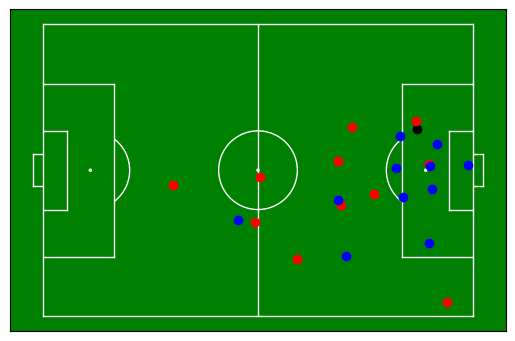

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
pitch.plot(ax = ax)
xy_objects['firstHalf']['Ball'].plot(ax = ax, t=2000)
xy_objects['firstHalf']['Home'].plot(ax = ax, t=2000, color = 'red')
xy_objects['firstHalf']['Away'].plot(ax = ax, t=2000, color = 'blue')
